In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.model_val_metrics_helper import select_threshold, metric_null, plot_intervention_counts

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.options.display.float_format = '{:,.4f}'.format

# I. Load and Preprocess data

In [2]:
pred_df = pd.read_csv('data/main_prospective_val_df_20220805_20220930_20221010.csv')
pred_df.dropna(subset=['Sepsis_Grouper'], inplace=True) #select only at risk group for plotting interventions (i.e. High Risk and Med. Risk Group)
pred_df.iloc[:, 4:]

/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (228) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DepartmentName,LocationAbbreviation,LOS,rel_time,abs_time,AdmissionInstant,AdmissionDateKey,etco2,SBP,DBP,HR,Resp,Temp,Weight,BMI,SpO2,gcs_total_score,MAP,ALKALINE PHOSPHATASE,APTT,"ARTERIAL PCO2, POC","ARTERIAL PH, POC","ARTERIAL PO2, POC",AST,BILIRUBIN TOTAL,BLOOD UREA NITROGEN,CALCIUM,CHLORIDE,CREATININE,FIBRINOGEN,"FIO2, ABG",GLUCOSE,HEMATOCRIT,HEMOGLOBIN,"LACTATE, ABG",MAGNESIUM,"OXYGEN PERCENT, ABG","PCO2, ABG","PH, ABG","PHOSPHORUS, INORGANIC",PLATELET COUNT,"PO2, ABG",POTASSIUM,SODIUM,WBC,AgeAtAdmissioninYears,sex_Female,sex_Male,etco2_interval_f1,etco2_interval_f2,etco2_diff,SBP_interval_f1,SBP_interval_f2,SBP_diff,DBP_interval_f1,DBP_interval_f2,DBP_diff,HR_interval_f1,HR_interval_f2,HR_diff,Resp_interval_f1,Resp_interval_f2,Resp_diff,Temp_interval_f1,Temp_interval_f2,Temp_diff,Weight_interval_f1,Weight_interval_f2,Weight_diff,BMI_interval_f1,BMI_interval_f2,BMI_diff,SpO2_interval_f1,SpO2_interval_f2,SpO2_diff,gcs_total_score_interval_f1,gcs_total_score_interval_f2,gcs_total_score_diff,MAP_interval_f1,MAP_interval_f2,MAP_diff,ALKALINE PHOSPHATASE_interval_f1,ALKALINE PHOSPHATASE_interval_f2,ALKALINE PHOSPHATASE_diff,APTT_interval_f1,APTT_interval_f2,APTT_diff,"ARTERIAL PCO2, POC_interval_f1","ARTERIAL PCO2, POC_interval_f2","ARTERIAL PCO2, POC_diff","ARTERIAL PH, POC_interval_f1","ARTERIAL PH, POC_interval_f2","ARTERIAL PH, POC_diff","ARTERIAL PO2, POC_interval_f1","ARTERIAL PO2, POC_interval_f2","ARTERIAL PO2, POC_diff",AST_interval_f1,AST_interval_f2,AST_diff,BILIRUBIN TOTAL_interval_f1,BILIRUBIN TOTAL_interval_f2,BILIRUBIN TOTAL_diff,BLOOD UREA NITROGEN_interval_f1,BLOOD UREA NITROGEN_interval_f2,BLOOD UREA NITROGEN_diff,CALCIUM_interval_f1,CALCIUM_interval_f2,CALCIUM_diff,CHLORIDE_interval_f1,CHLORIDE_interval_f2,CHLORIDE_diff,CREATININE_interval_f1,CREATININE_interval_f2,CREATININE_diff,"FIO2, ABG_interval_f1","FIO2, ABG_interval_f2","FIO2, ABG_diff",GLUCOSE_interval_f1,GLUCOSE_interval_f2,GLUCOSE_diff,HEMATOCRIT_interval_f1,HEMATOCRIT_interval_f2,HEMATOCRIT_diff,HEMOGLOBIN_interval_f1,HEMOGLOBIN_interval_f2,HEMOGLOBIN_diff,"LACTATE, ABG_interval_f1","LACTATE, ABG_interval_f2","LACTATE, ABG_diff",MAGNESIUM_interval_f1,MAGNESIUM_interval_f2,MAGNESIUM_diff,"OXYGEN PERCENT, ABG_interval_f1","OXYGEN PERCENT, ABG_interval_f2","OXYGEN PERCENT, ABG_diff","PCO2, ABG_interval_f1","PCO2, ABG_interval_f2","PCO2, ABG_diff","PH, ABG_interval_f1","PH, ABG_interval_f2","PH, ABG_diff","PHOSPHORUS, INORGANIC_interval_f1","PHOSPHORUS, INORGANIC_interval_f2","PHOSPHORUS, INORGANIC_diff",PLATELET COUNT_interval_f1,PLATELET COUNT_interval_f2,PLATELET COUNT_diff,"PO2, ABG_interval_f1","PO2, ABG_interval_f2","PO2, ABG_diff",POTASSIUM_interval_f1,POTASSIUM_interval_f2,POTASSIUM_diff,SODIUM_interval_f1,SODIUM_interval_f2,SODIUM_diff,WBC_interval_f1,WBC_interval_f2,WBC_diff,HR_mean,O2Sat_mean,SBP_mean,MAP_mean,Resp_mean,O2Sat_median,SBP_median,MAP_median,Resp_median,O2Sat_min,SBP_min,MAP_min,Resp_min,O2Sat_max,SBP_max,MAP_max,Resp_max,O2Sat_std,SBP_std,MAP_std,Resp_std,O2Sat_dstd,SBP_dstd,MAP_dstd,Resp_dstd,HR_score,Temp_score,Resp_score,MAP_score,qsofa,SIRS,PredictedProbability,SepsisLabel_0.005,SepsisLabel_0.01,SepsisLabel_0.02,SepsisLabel_0.03,SepsisLabel_0.04,SepsisLabel_0.05,SepsisLabel_0.06,SepsisLabel_0.07,SepsisLabel_0.09,SepsisLabel_0.1,SepsisLabel_0.15,SepsisLabel_0.2,SepsisLabel_0.25,SepsisLabel_0.3,SepsisLabel_0.4,SepsisLabel_0.5,Prediction_Time,DischargeInstant,DischargeDateKey,Sepsis_ICD_List,Sepsis_Case,Lactate_Values,Lactate_Ordered,Abx_Medication_Values,Abx_Ordered,Vent_Values,IMV,Vasopressor_Medication_Values,Vasopressor_Ordered,Blood_Culture_Values,Blood_Culture_Ordered,INR_MELD_ResultInstant,INR_MELD_Value,Sepsis_Grouper,Liver_Comorbidity,Cardiovascular_Comorbidity,Respiratory_Comorbidity,Renal_Comorbidity,Immunocompromised_Comorbidity,AKI_Comorbidity,apache_ii_score,apache_ii_Positive,Bilirubin_MELD,Creatinine_MELD,Sodium_MELD,INR_MELD,MELD_Score,MELD_Score_Positive
0,LI NW 1 MB 1400,NYUWH,0.0000,0.5000,2022-07-24 2

In [3]:
def sepsis_intervention_counts(pred_df, intervention): 
    intervention_df = pred_df.copy()
    intervention_df = intervention_df.groupby('Sepsis_Grouper')[intervention].value_counts().reset_index(name='Counts')
    intervention_df = intervention_df[intervention_df[intervention] == 1]
    intervention_df['Intervention'] = intervention
    return intervention_df[['Sepsis_Grouper', 'Counts', 'Intervention']]


pred_df['Sepsis_Intervention_Grouper'] = pred_df[['IMV', 'Lactate_Ordered', 'Abx_Ordered', 'Vasopressor_Ordered', 'Blood_Culture_Ordered']].max(axis=1)
plot_df = pred_df.copy()
plot_df.rename(columns={'Sepsis_Intervention_Grouper': 'Intervention\nGrouper', 'Lactate_Ordered': 'Lactate Lab\nOrder', 'Abx_Ordered':'Antibiotic\nAdministration', 'Vasopressor_Ordered':'Vasopressor & Inotrope\nAdministration', 'IMV':'Mechanical\nVentilation', 'Blood_Culture_Ordered':'Blood Culture\nOrder'}, inplace=True)

interventions = ['Intervention\nGrouper','Blood Culture\nOrder', 'Lactate Lab\nOrder', 'Antibiotic\nAdministration', 'Vasopressor & Inotrope\nAdministration', 'Mechanical\nVentilation']
plot_df_w_bc = pd.concat([sepsis_intervention_counts(plot_df, intervention) for intervention in interventions if intervention])

# II. Plot Intervention Counts

In [4]:
plot_df_w_bc

,Sepsis_Grouper,Counts,Intervention
0,"High Risk, ML Sepsis Score (0.5, 1.0], N=1834",1582,Intervention\nGrouper
2,"Medium Risk, ML Sepsis Score [0.25, 0.31), N=1844",1315,Intervention\nGrouper
0,"High Risk, ML Sepsis Score (0.5, 1.0], N=1834",1316,Blood Culture\nOrder
2,"Medium Risk, ML Sepsis Score [0.25, 0.31), N=1844",1056,Blood Culture\nOrder
1,"High Risk, ML Sepsis Score (0.5, 1.0], N=1834",767,Lactate Lab\nOrder
3,"Medium Risk, ML Sepsis Score [0.25, 0.31), N=1844",324,Lactate Lab\nOrder
1,"High Risk, ML Sepsis Score (0.5, 1.0], N=1834",506,Antibiotic\nAdministration
3,"Medium Risk, ML Sepsis Score [0.25, 0.31), N=1844",318,Antibiotic\nAdministration
1,"High Risk, ML Sepsis Score (0.5, 1.0], N=1834",428,Vasopressor & Inotrope\nAdministration
3,"Medium Risk, ML Sepsis Score [0.25, 0.31), N=1844",63,Vasopressor & Inotrope\nAdministration


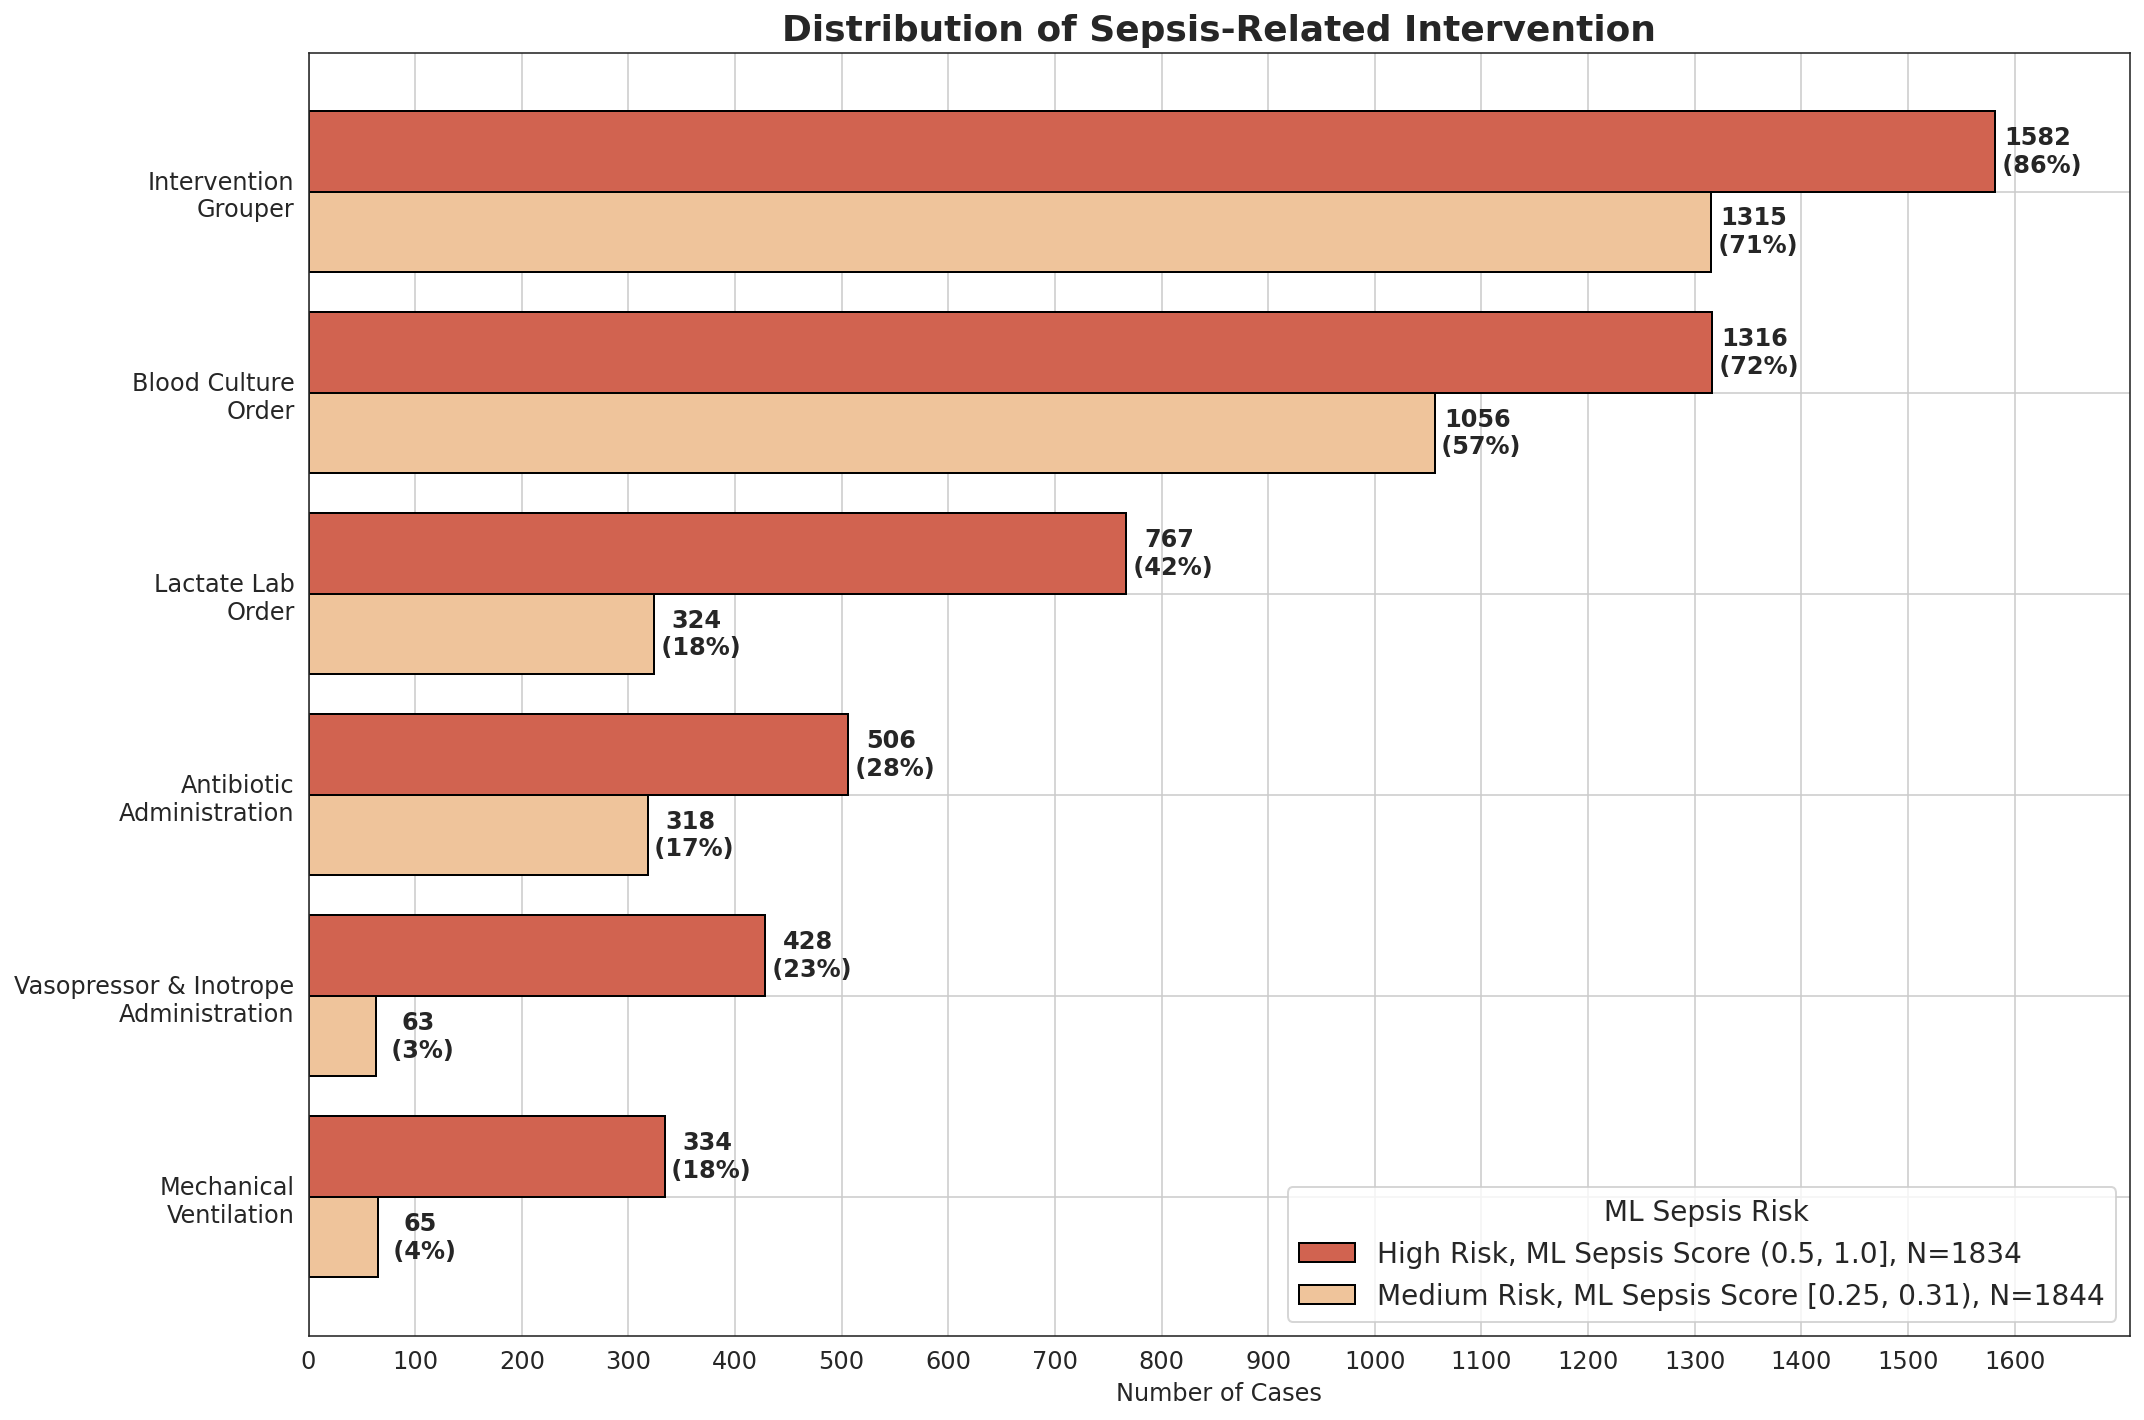

In [5]:
plot_intervention_counts(plot_df_w_bc)